In [1]:
import tensorflow as tf
from u_net import u_net
import os
import datetime
import matplotlib.pyplot as plt

In [2]:
def file_list_generation(path):
    for x,y,z in os.walk(path):
        path = x
        file_path = [ x+file_name for file_name in z]
    return file_path

In [3]:
trainX_file_path = file_list_generation('./dataset/images_prepped_train/')
trainY_file_path = file_list_generation('./dataset/annotations_prepped_train/')
valX_file_path = file_list_generation('./dataset/images_prepped_test/')
valY_file_path = file_list_generation('./dataset/annotations_prepped_test/')

In [4]:
print('There are {} images for training'.format(len(trainX_file_path)))
print('There are {} images for validation'.format(len(valX_file_path)))


There are 367 images for training
There are 101 images for validation


In [5]:
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'byciclist', 'void']

In [6]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=128, width=128):
  # Convert image and mask files to tensors 
  img_raw = tf.io.read_file(t_filename)
  anno_raw = tf.io.read_file(a_filename)
  image = tf.image.decode_jpeg(img_raw)
  annotation = tf.image.decode_jpeg(anno_raw)
 
  # Resize image and segmentation mask
  image = tf.image.resize(image, (height, width,))
  annotation = tf.image.resize(annotation, (height, width,))
  image = tf.reshape(image, (height, width, 3,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  annotation = tf.reshape(annotation, (height, width, 1,))
  stack_list = []

  # Reshape segmentation masks
  for c in range(len(class_names)):
    mask = tf.equal(annotation[:,:,0], tf.constant(c))
    stack_list.append(tf.cast(mask, dtype=tf.int32))
  
  annotation = tf.stack(stack_list, axis=2)

  # Normalize pixels in the input image
  image = image/127.5
  image -= 1

  return image, annotation

In [7]:
training_dataset = tf.data.Dataset.from_tensor_slices((trainX_file_path, trainY_file_path))
training_dataset = training_dataset.map(map_filename_to_image_and_mask)
training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
training_dataset = training_dataset.batch(32)
training_dataset = training_dataset.repeat()
training_dataset = training_dataset.prefetch(-1)

In [8]:
validation_dataset = tf.data.Dataset.from_tensor_slices((valX_file_path, valY_file_path))
validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
validation_dataset = validation_dataset.batch(32)
validation_dataset = validation_dataset.repeat() 

In [9]:
unet = u_net(OUTPUT_CHANNELS=12)
model = unet.unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
log_dir = "log/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
save_best = tf.keras.callbacks.ModelCheckpoint(filepath="u_net.h5",save_weights_only=False,monitor="val_accuracy", mode="max", save_best_only=True)

In [12]:
# number of training images
train_count = len(trainX_file_path)

validation_count = len(valX_file_path)

EPOCHS = 20
BATCH_SIZE = 16
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = validation_count//BATCH_SIZE

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, 
                    validation_data=validation_dataset, 
                    validation_steps=validation_steps, 
                    epochs=EPOCHS,
                    callbacks=[tensorboard_callback,save_best])

Epoch 1/20


2023-02-03 16:12:23.723605: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


22/22 [==============================] - 147s 7s/step - loss: 2.5186 - accuracy: 0.4086 - val_loss: 1.6670 - val_accuracy: 0.4776
Epoch 2/20
22/22 [==============================] - 142s 6s/step - loss: 1.6660 - accuracy: 0.5349 - val_loss: 1.4317 - val_accuracy: 0.5901
Epoch 3/20
22/22 [==============================] - 142s 6s/step - loss: 1.5829 - accuracy: 0.5592 - val_loss: 1.5647 - val_accuracy: 0.5864
Epoch 4/20
22/22 [==============================] - 138s 6s/step - loss: 1.1962 - accuracy: 0.6614 - val_loss: 1.2738 - val_accuracy: 0.6062
Epoch 5/20
22/22 [==============================] - 135s 6s/step - loss: 0.9907 - accuracy: 0.6861 - val_loss: 1.0250 - val_accuracy: 0.6207
Epoch 6/20
22/22 [==============================] - 144s 7s/step - loss: 0.9188 - accuracy: 0.7024 - val_loss: 0.9585 - val_accuracy: 0.6215
Epoch 7/20
22/22 [==============================] - 149s 7s/step - loss: 0.8798 - accuracy: 0.7130 - val_loss: 0.9723 - val_accuracy: 0.6135
Epoch 8/20
22/22 [======

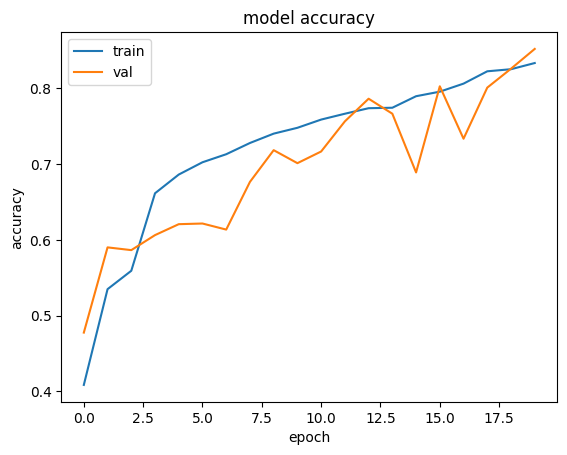

<Figure size 640x480 with 0 Axes>

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('accuracy_plot.png')

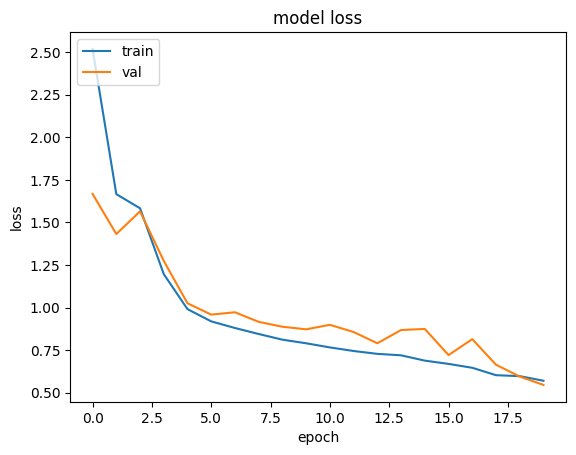

<Figure size 640x480 with 0 Axes>

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('loss_plot.png')